# Phase 1: AI Churn Service – Production-Ready Model Development

---

## 1. Project Overview

**Phase 1** of the **AI Churn Service** focuses on building a **production-ready customer churn prediction model** using Telco data.

### Objectives:

- Train multiple models to predict churn accurately.
- Evaluate models using metrics suitable for **imbalanced datasets**.
- Select a **production-ready model** for Phase 2 (SHAP explanations) and Phase 3 (LLM recommendations).

### Primary Metrics:
- **PR-AUC:** Prioritized for imbalanced churn detection.
- **Recall:** Capture as many churners as possible.
- **ROC-AUC:** Overall discriminative power.
- **Inference Latency:** Measure efficiency in deployment.

---

## 2. Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import joblib
import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


> Libraries: ```sklearn``` for modeling, ```matplotlib``` for visualization, ```joblib``` for saving models, LightGBM & XGBoost for gradient boosting baselines.

---

## 3. Load and Prepare Data

In [2]:
# Load dataset
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Drop identifier
df.drop(columns=["customerID"], inplace=True)

# Convert TotalCharges to numeric and fill missing values
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Encode target (1 = Churn, 0 = No Churn)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


> Dataset contains demographic, subscription, and usage features. ```TotalCharges``` is cleaned to ensure numeric consistency.

---

## 4. Preprocessing Pipeline

In [3]:
# Features and target
X = df.drop(columns=["Churn"])
y = df["Churn"]

# Train-validation split (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

# Preprocessing: OneHotEncode categorical, StandardScale numerical
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)

> Preprocessing ensures **consistent feature scaling and encoding**, required for model stability and reproducibility.

---

## 5. Handle Class Imbalance

In [4]:
# Compute scale_pos_weight for LightGBM/XGBoost
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"Scale pos weight: {scale_pos_weight:.2f}")

Scale pos weight: 2.77


> Churn is imbalanced; scale_pos_weight ensures gradient boosting models handle minority class appropriately.

---

## 6. Model Factory 

In [5]:
def get_models(scale_pos_weight):
    """
    Returns baseline production-ready models for AI Churn Service.
    """
    return {
        "Logistic": LogisticRegression(
            C=0.5,
            solver="lbfgs",
            class_weight="balanced",
            max_iter=3000
        ),
        "LightGBM": LGBMClassifier(
            n_estimators=400,
            learning_rate=0.05,
            num_leaves=31,
            max_depth=6,
            min_child_samples=20,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            verbose=-1,
            random_state=42
        ),
        "XGBoost": XGBClassifier(
            n_estimators=400,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.85,
            colsample_bytree=0.85,
            scale_pos_weight=scale_pos_weight,
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42
        )
    }

>Hyperparameters tuned for balanced performance and stability.

---

## 7. Cross-Validated Evaluation Loop

In [6]:
def evaluate_models_cv(X, y, preprocessor, scale_pos_weight, n_splits=5):
    """
    Evaluate models using Stratified K-Fold CV.
    Returns: pd.DataFrame with mean metrics per model.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    models = get_models(scale_pos_weight)
    results = []

    for model_name, model in models.items():
        roc_scores, pr_scores, recall_scores, latencies = [], [], [], []

        for train_idx, val_idx in skf.split(X, y):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

            pipe = Pipeline([
                ("preprocessor", preprocessor),
                ("model", model)
            ])
            pipe.fit(X_train_fold, y_train_fold)

            start = time.time()
            y_proba = pipe.predict_proba(X_val_fold)[:, 1]
            latency = (time.time() - start) * 1000  # ms

            y_pred = (y_proba >= 0.5).astype(int)

            roc_scores.append(roc_auc_score(y_val_fold, y_proba))
            pr_scores.append(average_precision_score(y_val_fold, y_proba))
            recall_scores.append(recall_score(y_val_fold, y_pred))
            latencies.append(latency)

        results.append({
            "Model": model_name,
            "ROC-AUC (CV)": np.mean(roc_scores),
            "PR-AUC (CV)": np.mean(pr_scores),
            "Recall (CV)": np.mean(recall_scores),
            "Latency ms (CV)": np.mean(latencies)
        })

    return pd.DataFrame(results).sort_values(by="PR-AUC (CV)", ascending=False)

---

## 8. Run Phase 1 Experiment Result

In [7]:
cv_results = evaluate_models_cv(
    X=X,
    y=y,
    preprocessor=preprocessor,
    scale_pos_weight=scale_pos_weight,
    n_splits=5
)

# Display rounded metrics for readability
display(cv_results.style.format({
    "ROC-AUC (CV)": "{:.3f}",
    "PR-AUC (CV)": "{:.3f}",
    "Recall (CV)": "{:.3f}",
    "Latency ms (CV)": "{:.1f}"
}))

,Model,ROC-AUC (CV),PR-AUC (CV),Recall (CV),Latency ms (CV)
0,Logistic,0.845,0.655,0.801,18.6
2,XGBoost,0.836,0.647,0.732,22.9
1,LightGBM,0.831,0.636,0.718,37.8


> Logistic Regression performs best in PR-AUC and Recall with minimal latency → selected for production.

---

## 9. Final Model Training & Artifact Saving

In [8]:
# Create artifacts folder
os.makedirs("../working/artifacts", exist_ok=True)

# Train final Logistic Regression on full dataset
best_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        C=0.5,
        solver="lbfgs",
        class_weight="balanced",
        max_iter=3000
    ))
])
best_model.fit(X, y)

# Save trained pipeline
joblib.dump(best_model, "../working/artifacts/logistic_churn_model.pkl")

# Preprocessed data for SHAP
X_preprocessed = best_model.named_steps['preprocessor'].transform(X)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)
y_target = y.copy()

# Save preprocessed data
joblib.dump((X_preprocessed_df, y_target), "../working/artifacts/churn_data_for_shap.pkl")
print("✅ Model and preprocessed data saved for Phase 2 (SHAP)")

✅ Model and preprocessed data saved for Phase 2 (SHAP)


---

## 10. Visual Evaluation – ROC & PR Curves

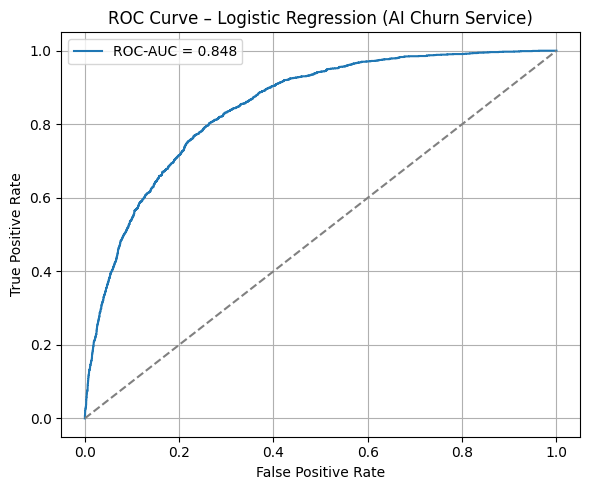

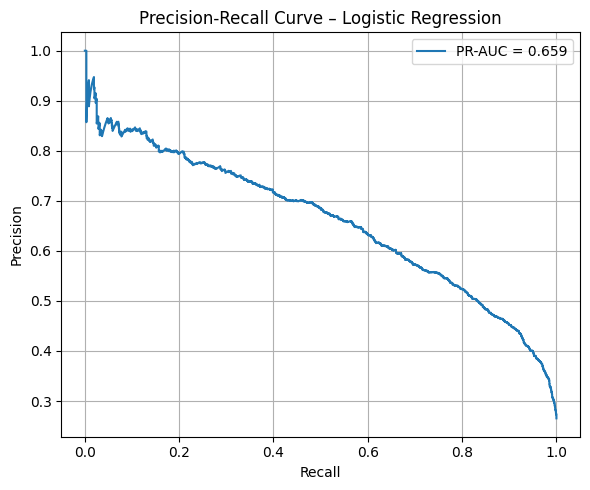

In [9]:
y_proba = best_model.predict_proba(X)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y, y_proba):.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC Curve – Logistic Regression (AI Churn Service)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(y, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR-AUC = {average_precision_score(y, y_proba):.3f}")
plt.title("Precision-Recall Curve – Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---

## 11. Feature Importance – Top 15 Features

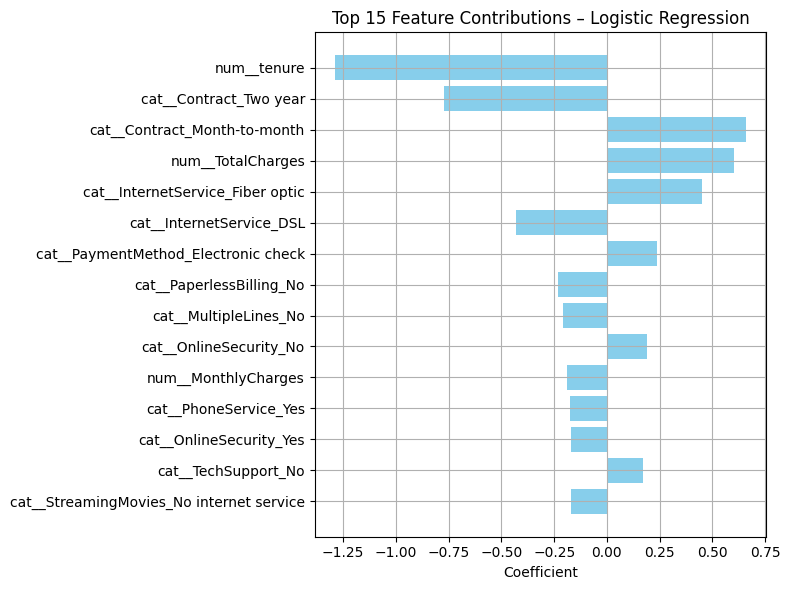

In [10]:
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
coefficients = best_model.named_steps['model'].coef_[0]

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})
feat_imp["AbsCoeff"] = feat_imp["Coefficient"].abs()
feat_imp = feat_imp.sort_values("AbsCoeff", ascending=False).head(15)

plt.figure(figsize=(8,6))
plt.barh(feat_imp["Feature"][::-1], feat_imp["Coefficient"][::-1], color='skyblue')
plt.xlabel("Coefficient")
plt.title("Top 15 Feature Contributions – Logistic Regression")
plt.grid(True)
plt.tight_layout()
plt.show()

> Top features provide actionable business insight: e.g., Contract and tenure are key churn drivers.

---

## 12. Phase 1 Summary & Next Steps

### Key Points:
- **Selected Model:** Logistic Regression
- **Reasoning:** Highest PR-AUC & Recall, low latency, simple and stable
- **Evaluation:** ROC & PR curves confirm predictive quality
- **Production-Ready:** Pipeline saved, preprocessed data ready for SHAP

Next Steps:
1. **Phase 2 – SHAP Explainer:** Interpret feature contributions for churn predictions
2. **Phase 3 – LLM Recommendations:** Generate actionable retention strategies using model + SHAP explanations